In [1]:
import matplotlib.pyplot as plt

import numpy as np
import numpy.ma as ma
import math

import tensorflow as tf
from tensorflow.keras.models import load_model

import cartopy
import cartopy.crs as ccrs

import pandas as pd

import datetime
from datetime import datetime, timedelta

from glob import glob

from tools.target_data_generator import *
from tools.predictor_data_generator import *
from tools.utils import *

!pip install scitools-iris
import iris

import warnings
warnings.filterwarnings('ignore')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


# PART 1: Generate SII-NowNet Nowcast

## a) User inputs

In [14]:
# These are the coordinate limits and time of the example test data
max_lon = 107
min_lon = 94.63
max_lat = 5.98
min_lat = -6.38

# number of hours into the future we want to predict
lead_time = 1

# YYYYMMDDHH of the UTC valid time (current time plus lead time)
time = '2018020109'

# this variable sets the number of himawari BT pixels within each prediction grid in the x and y direction (must be square)
# this example uses 21, resulting in prediction grids of 21x21 pixels
no_of_pixels_per_prediction_grid = 21

## b) Load data

In [13]:
year = time[:4]
month = time[4:6]
day = time[6:8]
valid_time = time[-2:]

# load the T-0 hours (i.e. current time) and T-2 hour himawari 10.4um BT images and constrain to your chosen domain 
T_0_cube = iris.load('./tools/test_data/himawari_10.4_' + year + month + day + '_' + "%02d"%(int(valid_time)-lead_time) + '00.nc')[0].extract(iris.Constraint(latitude = lambda x: min_lat <= x <= max_lat, 
                                                                                                                                             longitude = lambda x: min_lon <= x <= max_lon))    
T_2_cube = iris.load('./tools/test_data/himawari_10.4_' + year + month + day + '_' + "%02d"%(int(valid_time)-lead_time-2) + '00.nc')[0].extract(iris.Constraint(latitude = lambda x: min_lat <= x <= max_lat, 
                                                                                                                                               longitude = lambda x: min_lon <= x <= max_lon))    

# load the orography data and constrain to your chosen domain (same domain as BT images)
orog_cube = iris.load('./tools/test_data/globe_mc.nc').extract(iris.Constraint(latitude = lambda x: min_lat <= x <= max_lat,
                                                             longitude = lambda x: min_lon <= x <= max_lon))[0]  

# ororgraphy data must be regridded to match the himawari BT data
orog_cube.coord('longitude').coord_system = T_0_cube.coord('longitude').coord_system
orog_cube.coord('latitude').coord_system = T_0_cube.coord('latitude').coord_system
orog_cube = orog_cube.regrid(T_0_cube, iris.analysis.Linear())

# convert each data field to a numpy array (negative orography values are converted to 0)
T_0_data = np.array(T_0_cube.data)
T_2_data = np.array(T_2_cube.data)
orog_data = np.array(orog_cube.data)
orog_data = np.where(orog_data<0, 0, orog_data)

## c) Prepare input

In [8]:
# calculate the number of prediction grids that fit into the domain
no_x_grids = T_0_data.shape[0]/no_of_pixels_per_prediction_grid
no_y_grids = T_0_data.shape[1]/no_of_pixels_per_prediction_grid

# checks that a whole number of prediction grids fits into the domain
# important to choose a no_of_pixels_per_prediction_grid value that is a multiple of domain dimensions
if (no_x_grids != int(no_x_grids)) or (no_y_grids != int(no_y_grids)):
    print('Prediction grid pixel resolution must be a multiple of input data dimension')

# produces the input data for each prediction tile across the domain
T_0_tiles = generate_tiles(T_0_data, no_x_grids, no_y_grids, no_of_pixels_per_prediction_grid, 1)
T_2_tiles = generate_tiles(T_2_data, no_x_grids, no_y_grids, no_of_pixels_per_prediction_grid, 1)
orog_tiles = generate_tiles(orog_data, no_x_grids, no_y_grids, no_of_pixels_per_prediction_grid, 1)

input_data = np.stack([T_0_tiles, T_2_tiles-T_0_tiles, orog_tiles])

print(input_data.shape)

(3, 324, 63, 63)


## d) Load SII-NowNet model and generate nowcast

In [23]:
# load the pre-trained intensification model
intens_path = './tools/models/intensification/' + str(lead_time) + '_model'
intens_model = load_model(intens_path)

# load the pre-trained initiation model
init_path = './tools/models/initiation/' + str(lead_time) + '_model'
init_model = load_model(init_path)

# normalise the values
norm_input = prepare_test_input(input_data)

# norm_input must be of shape (total number of prediction grids x number of X pixels x number of Y pixels x number of channels)
print(norm_input.shape)

# produce the nowcasts
intens_predictions = intens_model.predict(norm_input, verbose=0)[:,0]
intens_nowcast = intens_predictions.reshape(18,18)
intens_nowcast = np.pad(intens_nowcast, 1, mode='constant', constant_values=np.nan)

init_predictions = init_model.predict(norm_input, verbose=0)[:,0]
init_nowcast = init_predictions.reshape(18,18)
init_nowcast = np.pad(init_nowcast, 1, mode='constant', constant_values=np.nan)

(324, 63, 63, 3)


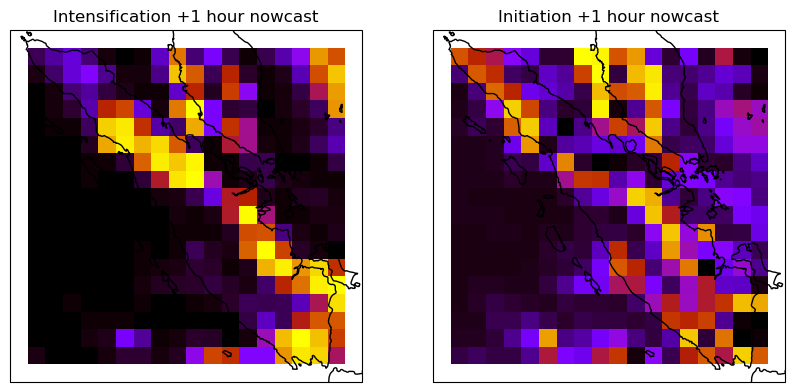

In [19]:
#Plot the results

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(121, projection = ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()
ax.imshow(intens_nowcast, origin = 'lower', extent = (min_lon, max_lon, min_lat, max_lat), cmap='gnuplot')
ax.set_title('Intensification +1 hour nowcast')

ax = fig.add_subplot(122, projection = ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()
ax.imshow(init_nowcast, origin = 'lower', extent = (min_lon, max_lon, min_lat, max_lat), cmap='gnuplot')
ax.set_title('Initiation +1 hour nowcast')

plt.show()

# PART 2: Verification

In [10]:
# if you have the himawari BT data at the valid time then it is possible to verify the nowcast
# firstly load the BT data at the valid time
T_valid_cube = iris.load('./tools/test_data/himawari_10.4_' + year + month + day + '_' + valid_time + '00.nc')[0].extract(iris.Constraint(latitude = lambda x: min_lat <= x <= max_lat, 
                                                                                                                                          longitude = lambda x: min_lon <= x <= max_lon))    

data = np.stack([T_0_data, np.array(T_valid_cube.data)]) 

df_init = initiation_target_generator(data, 
                                      time, 
                                      20, 
                                      0.05, 
                                      235, 
                                      20, 
                                      0.05, 
                                      21)

df_intens = intensification_target_generator(data, 
                                             time,
                                             20, 
                                             0.05,
                                             235,
                                             21)

## Visualise

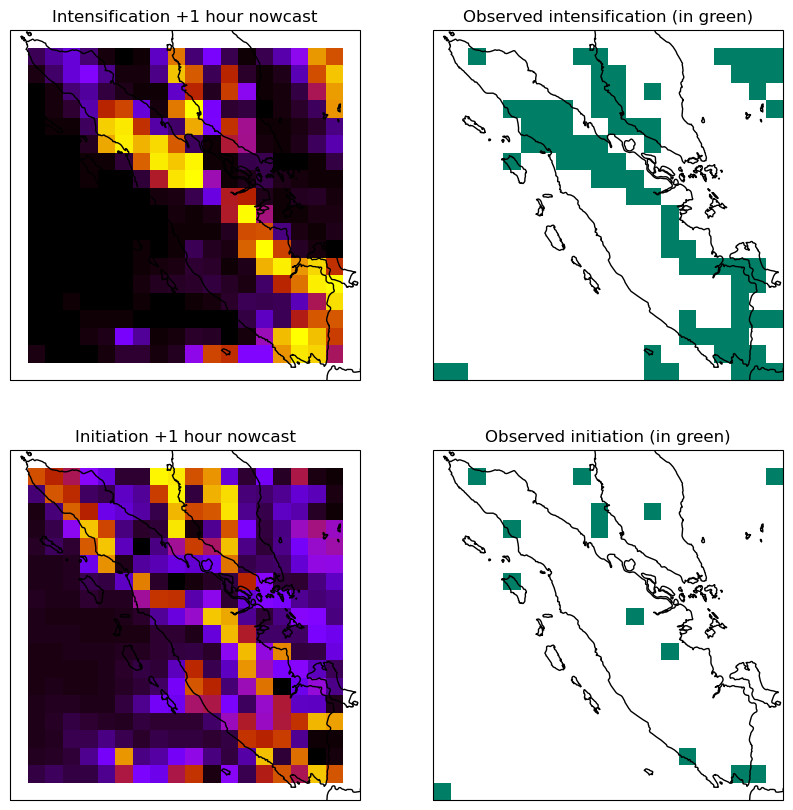

In [22]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(221, projection = ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()
ax.imshow(intens_nowcast, origin = 'lower', extent = (min_lon, max_lon, min_lat, max_lat), cmap='gnuplot')
ax.set_title('Intensification +1 hour nowcast')

ax = fig.add_subplot(222, projection = ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()
ax.imshow(np.where(df_intens['scaled_convection_target'][0]==0,np.nan,1), origin = 'lower', extent = (min_lon, max_lon, min_lat, max_lat), cmap='summer')
ax.set_title('Observed intensification (in green)')

ax = fig.add_subplot(223, projection = ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()
ax.imshow(init_nowcast, origin = 'lower', vmin=0,vmax=1, extent = (min_lon, max_lon, min_lat, max_lat), cmap='gnuplot')
ax.set_title('Initiation +1 hour nowcast')

ax = fig.add_subplot(224, projection = ccrs.PlateCarree())
ax.set(xlim=[min_lon,max_lon], ylim=[min_lat,max_lat], transform = ccrs.PlateCarree())
ax.coastlines()
ax.imshow(np.where(df_init['scaled_convection_target'][0]==0,np.nan,1), origin = 'lower', extent = (min_lon, max_lon, min_lat, max_lat), cmap='summer')
ax.set_title('Observed initiation (in green)')

plt.show()
